# Data block foundations, in Swifty/functional style

In [ ]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/FastaiNotebook_07_batchnorm")' FastaiNotebook_07_batchnorm
%install '.package(path: "$cwd/SwiftCV")' SwiftCV

Installing packages:
	.package(path: "/home/ubuntu/fastai_docs/dev_swift/FastaiNotebook_07_batchnorm")
		FastaiNotebook_07_batchnorm
	.package(path: "/home/ubuntu/fastai_docs/dev_swift/SwiftCV")
		SwiftCV
With SwiftPM flags: []
Working in: /tmp/tmpj4pxwi03/swift-install
Compile Swift Module 'jupyterInstalledPackages' (1 sources)
Initializing Swift...
Installation complete!


In [ ]:
import Path
import TensorFlow
import Python

In [ ]:
import FastaiNotebook_07_batchnorm

In [ ]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


## DataBlock-like manipulation in a lightweight functional, Swifty style

The DataBlock API in Python is designed to help with the routine data manipulations involved in modelling: downloading data, loading it given an understanding of its layout on the filesystem, processing it, and feeding it into an ML framework like fastai. This is a data pipeline. How do we do this in Swift?

One approach is to build a set of types (structs, protocols, etc.) which represent various stages of this pipeline. By making the types generic, we could build a library that handled data for many kinds of models. However, it is sometimes a good rule of thumb, before writing generic types, to start by writing concrete types and then to notice what to abstract into a generic later. And another good rule of thumb, before writing concrete types, is to write no types at all, and to see how far you can get with a more primitive tool for composition: functions.

This notebook shows how to perform DataBlock-like operations using a _lightweight functional style_. This means, first, to rely as much as possible on _pure_ functions -- that is, functions which do nothing but return outputs based on their inputs, and which don't mutate values anywhere. Second, in particular, it means to use Swift's support for _higher-order functions_ (functions which take functions, like `map`, `filter`, `reduce`, and `compose`). Finally, this example relies on _tuples_. Like structs, tuples can have named, typed properties. Unlike structs, you don't need to name them. They can be a fast, ad-hoc way to explore the data types that you actually need, without being distracted by considering what's a method, an initializer, etc.,

Swift has excellent, understated support for a such a style. 

## Getting Started

First things first, we need to download Imagenette and untar it. What follows is very close to what we did for MNIST.

In [ ]:
public let dataPath = Path.home/".fastai"/"data"

In [ ]:
public func downloadImagenette(path: Path = dataPath, sz:String="-160") -> Path {
    let url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette\(sz).tgz"
    let fname = "imagenette\(sz)"
    let file = path/fname
    try! path.mkdir(.p)
    if !file.exists {
        downloadFile(url, dest:(path/"\(fname).tgz").string)
        _ = "/bin/tar".shell("-xzf", (path/"\(fname).tgz").string, "-C", path.string)
    }
    return file
}

### Defining Imagenette configurations

Here is what we know ahead of time about how imagenette data is laid out on disk:

```
.
└── data                                           # <-- this is the fastai data root path
    ├── imagenette-160                             # <-- this is the imagenette dataset path
    │   ├── train                                  # <-- the train/ and val/ dirs are our two segments
    │   │   ├── n01440764                          # <-- this is an image category _label_
    │   │   │   ├── n01440764_10026.JPEG           # <-- this is an image (a _sample_) with that label
    │   │   │   ├── n01440764_10027.JPEG
    │   │   │   ├── n01440764_10042.JPEG
   ...
    │   ├── val
    │       └── n03888257
    │           ├── ILSVRC2012_val_00001440.JPEG
    │           ├── ILSVRC2012_val_00002508.JPEG
   ...  

```


We will define one type, an `enum`, to capture this information.

This "empty" `enum` will serve only as a namespace, a grouping, for pure functions representing this information. By putting this information into one type, our code is more modular: it more clearly distinguishes facts about _this dataset_, from _general purpose data manipulators_, from _computations for this analysis_.

Here's our Imagenette configuration type:

In [ ]:
// export
enum ImageNette
{
  /// Downloads imagenette given the fastai data, and returns its "dataset root"
  static func download() -> Path { return downloadImagenette() }

  /// Extensions of paths which represent imagenette samples (i.e., items)
  static var sampleExtensions:[String] = ["jpeg", "jpg"]

  // Returns whether an image is in the training set (vs validation set), based on its path
  static func isTraining(_ p:Path) -> Bool {
    return p.parent.parent.basename() == "train"
  }

  /// Returns an image's label given the image's path
  static func labelOf(_ p:Path) -> String { return p.parent.basename() }
}

### Download Imagenette

In [ ]:
let path = ImageNette.download()

After download, this `path` is the first _value_, and the remaining steps of analysis can all be seen as applying functions which successively compute new values from past values.

For instance, this path and the allowed files extensions are the _input_ to the function `collectFilePaths(under:filteringToExtensions)` which _outputs_ an array of all samples in the dataet. (This is like `fetchFiles` but we rename it here to to emphasize the conventional functional operation of "filtering" and to reflect that it does not actually fetch files over the network:

In [ ]:
/// returns a list of files under `path` with the specified extensions
func collectFilePaths(under path:Path,
                      filteringToExtensions extensions:[String]) -> [Path] {
    var res: [Path] = []
    for p in try! path.ls(){
        if p.kind == .directory { 
            res += collectFilePaths(under: p.path, filteringToExtensions: extensions)
        } else if extensions.contains(p.path.extension.lowercased()) {
            res.append(p.path)
        }
    }
    return res
}

Now we compute the next value, the array of all paths.

In [ ]:
var allPaths = collectFilePaths(under: path, filteringToExtensions:ImageNette.sampleExtensions)

If we look at a random element, compared to the imagenette root, it has the filesystem layout structure we expected

In [ ]:
(path.string, allPaths.randomElement()!.string)

▿ 2 elements
  - .0 : "/home/ubuntu/.fastai/data/imagenette-160"
  - .1 : "/home/ubuntu/.fastai/data/imagenette-160/train/n03417042/n03417042_5699.JPEG"


Let us verify that our configurations functions correctly encode the segment (train or val) and the label of an arbitrary item:

In [ ]:
func describeSample(_ path:Path) 
{
    let isTraining = ImageNette.isTraining(path)
    let label = ImageNette.labelOf(path)
    print("""
          path: \(path.string)
          training?:  \(isTraining)
          label: \(label)
          """)
}


In [ ]:
describeSample(allPaths.randomElement()!)

path: /home/ubuntu/.fastai/data/imagenette-160/train/n02979186/n02979186_15319.JPEG
training?:  true
label: n02979186


We can see that our functions for _path->isTraining_ and _path->label_ are working as expected.

### Split the data

Now we want to split our samples into a training and validation sets. Since this is so routine we define a standard function that does so.

It is enough to take an array and returns a named tuple of two arrays, one for training and one for validation.

In [ ]:
// export

/// takes a [T] of items, and returns a tuple (train:[T],val:[T]) items
func partitionIntoTrainVal<T>(_ items:[T],isTrain:((T)->Bool)) -> (train:[T],val:[T])
{
  var result = items 
  let pivot = result.partition(by: isTrain)
  let train = Array(result[pivot...])
  let val = Array(result[..<pivot])
  return (train:train,val:val)
}

We pass the `ImageNette.isTraining` test function into the partitioner directly

In [ ]:
var samples = partitionIntoTrainVal(allPaths, isTrain:ImageNette.isTraining)

And verify that it works as expected:

In [ ]:
describeSample(samples.val.randomElement()!)

path: /home/ubuntu/.fastai/data/imagenette-160/val/n03888257/ILSVRC2012_val_00047147.JPEG
training?:  false
label: n03888257


In [ ]:
describeSample(samples.train.randomElement()!)

path: /home/ubuntu/.fastai/data/imagenette-160/train/n03445777/n03445777_10693.JPEG
training?:  true
label: n03445777


### Process the data

We process the data by taking all training labels, uniquing them, sorting them, and then defining an integer to represent the label.

Those numerical labels let us define two functions, a function for label->number and the inverse function number->label.

But notable point is that the process that produces those functions _is also a function_: the input is a list of training labels, and the output is the label<->number bidirectional mappings.

That function which creates the bidirectional mapping is just the initializer of the String<->Int mapper we define below:

In [ ]:
// export
/// Defines bidirectional maps from String <-> Int32, initialized from a collection of Strings
public struct StringIntMapper {
  private(set) public var labelMap:[String]
  private(set) public var inverseLabelMap:[String:Int]
  public init<S:Sequence>(labels ls:S) where S.Element == String {
    labelMap = Array(Set(ls)).sorted()
    inverseLabelMap = Dictionary(uniqueKeysWithValues:
      labelMap.enumerated().map({ ($0.element, $0.offset) }))
  }
  public func labelToInt(_ label:String) -> Int { return inverseLabelMap[label]! }
  public func intToLabel(_ labelIndex:Int) -> String { return labelMap[labelIndex] }
}

Let us create a labelNumber mapper from the training data:

In [ ]:
var trainLabels = samples.train.map(ImageNette.labelOf)
var labelMapper = StringIntMapper(labels: trainLabels)

The labelMapper now supplies the two bidirectional functions. We can verify they have the required inverse relationship:

In [ ]:
var randomLabel = labelMapper.labelMap.randomElement()!
print("label = \(randomLabel)")
var numericalizedLabel = labelMapper.labelToInt(randomLabel)
print("number = \(numericalizedLabel)")
var labelFromNumber = labelMapper.intToLabel(numericalizedLabel)
print("label = \(labelFromNumber)")

label = n03000684
number = 3
label = n03000684


### Label the data

Now we are in a position to give the data numerical labels.

Now in order to map from a sample item (a `Path`), to a numerical label (an `Int32)`, we just compose our Path->label function with a label->int function. Curiously, Swift does not define its own compose function, so we define `compose` ourselves and use it to create our new function as a composition explicitly:

In [ ]:
// export
/// g(f(x)) == (compose(f,g))(x)
func compose<A,B,C>(_ f: @escaping (A) -> B,
                    _ g: @escaping (B) -> C) -> ((A) -> C) {
  return { (a:A) -> C in
    return g(f(a))
  }
}

In [ ]:
// Define a function which map a raw sample (Path) to a numericalized label (Int)
var pathToNumericalizedLabel = compose(ImageNette.labelOf, labelMapper.labelToInt)

Now we can, if we wish, compute numericalized labels over ll the training and validation items:

In [ ]:
var trainNumLabels = samples.train.map(pathToNumericalizedLabel)
var valNumLabels = samples.val.map(pathToNumericalizedLabel)

We've gotten pretty far just using mostly just variables, functions, and function composition. But one downside is that our results are now scattered over a few different variables, `samples`, `trainNumLabels`, `valNumLabels`. If we wanted to collect these values into one structure for convenience, we could even use a named tuple for this as well:

In [ ]:
typealias SplitLabeledDataResults = (
  mapper: StringIntMapper,
  train:(
    items:[Path],
    labels:[Int]),
  val:(
    items:[Path],
    labels:[Int])
)
var results:SplitLabeledDataResults = (mapper: labelMapper,
                       train: (samples.train,trainNumLabels),
                       val:   (samples.val,valNumLabels))

We can now, if we wish, define a single function that reproduces all our calculations, starting with the first value, the array of all paths. The sequence of function calls, each using inputs from the previous function, and returning a constant, value-semantic type, is a functional style.

In [ ]:
func splitLabeledData(paths:[Path]) -> SplitLabeledDataResults
{
    let samples = partitionIntoTrainVal(paths, isTrain:ImageNette.isTraining)
    let trainLabels = samples.train.map(ImageNette.labelOf)
    let labelMapper = StringIntMapper(labels:trainLabels)
    let pathToNumericalizedLabel = compose(ImageNette.labelOf, labelMapper.labelToInt)
    let results:SplitLabeledDataResults = (mapper:labelMapper,
                   train:(samples.train,samples.train.map(pathToNumericalizedLabel)),
                   val:(samples.val,samples.val.map(pathToNumericalizedLabel)))
    return results
}

If this is the output shape we find convenient, we would define a custom struct instead of relying on nested tuples.

But starting with tuples makes it easier to see the pure functions at work, which might have been obscured if we had started by thinking of functions as methods that "belong" to one type or another. Some functions want to be free!

### opening images

We can use the same compose approach to convert our images from `Path` filenames to resized images.

In [ ]:
import Foundation
import SwiftCV

In [ ]:
func openImage(_ fn: Path) -> Mat {
    return imdecode(try! Data(contentsOf: fn.url))
}

In [ ]:
func showCVImage(_ img: Mat) {
    let tensImg = Tensor<UInt8>(cvMat: img)!
    let numpyImg = tensImg.makeNumpyArray()
    plt.imshow(numpyImg) 
    plt.axis("off")
    plt.show()
}

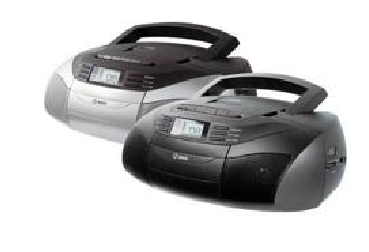

In [ ]:
showCVImage(openImage(results.train.0.randomElement()!))

In [ ]:
func decodeRGB(_ img: Mat) -> Mat {
    return cvtColor(img, nil, ColorConversionCode.COLOR_BGR2RGB)
}

In [ ]:
func resize(_ img: Mat, size: Int) -> Mat {
    return resize(img, nil, Size(size, size), 0, 0, InterpolationFlag.INTER_LINEAR)
}

In [ ]:
var transforms = compose(openImage, decodeRGB)
transforms = compose(transforms) { resize($0, size: 224) }

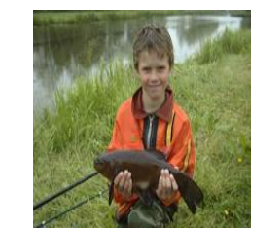

In [ ]:
showCVImage(transforms(results.train.0.randomElement()!))

### chunking, and transforming into Tensors

Possible next steps:

- to go from `SplitLabeledDataResults` to `DataBatch`.
- move transformation, shuffling, and batching into functional pipeline operations, between simple structs.
- probably greatly simplifyng DataBunch and FADataset
- remove unnecessary generics


In [ ]:
// // export
// public func pathsToTensor(_ paths: [Path]) -> StringTensor { return StringTensor(paths.map{ $0.string })}
// public func numlabelsToTensor(_ numlabels: [Int32]) -> Tensor<Int32> { return Tensor<Int32>(numlabels)}


// func dataBatch(from sldr:SplitLabeledDataResults) -> DataBatch<TF, Tensor<Int32>>?
// {
//     var trainEl = LabeledElement(xb: pathsToTensor(sldr.train.items),
//                    yb: numlabelsToTensor(sldr.train.labels))
//     var valEl = LabeledElement(xb: pathsToTensor(sldr.val.items),
//                    yb: numlabelsToTensor(sldr.val.labels))

//     let inputs:TF = 
//     let labels:Tensor<Int32> = 
//    var batch = DataBatch.init(xb:inputs, yb:labels)
//     return nil
//    return batch
// }